In [1]:
!wget http://mattmahoney.net/dc/enwik8.zip
!unzip -q enwik8.zip

--2026-01-06 20:53:11--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 20.119.76.151
Connecting to mattmahoney.net (mattmahoney.net)|20.119.76.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘enwik8.zip’

enwik8.zip          100%[===================>]  34.76M  29.1MB/s    in 1.2s    

2026-01-06 20:53:12 (29.1 MB/s) - ‘enwik8.zip’ saved [36445475/36445475]



In [2]:
import re
from collections import Counter

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    return text.split()

with open("enwik8", "r", encoding="utf-8") as f:
    text = f.read()

tokens_all = preprocess(text)
print("Total Tokens:", len(tokens_all))


min_count = 5
counts = Counter(tokens_all)
vocabulary = {w:c for w,c in counts.items() if c >= min_count}

index2word = list(vocabulary.keys())
word2index = {w:i for i,w in enumerate(index2word)}

print("Vocabulary Size:", len(index2word))

tokens = [w for w in tokens_all if w in word2index]

Total Tokens: 14480993
Vocabulary Size: 71993


In [3]:
window = 2

pairs = []

print("Tokens used for pairs:", len(tokens))

for i,w in enumerate(tokens):
    center = word2index[w]
    for j in range(max(0, i-window), min(len(tokens), i+window+1)):
        if i == j:
            continue
        context = word2index[tokens[j]]
        pairs.append((center, context))

print("Training Pairs:", len(pairs))

Tokens used for pairs: 14146144
Training Pairs: 56584570


In [4]:
import numpy as np

vocabulary_size = len(index2word)

counts_arr = np.array([vocabulary[w] for w in index2word], dtype=np.float32)
neg_dist = counts_arr ** 0.75
neg_dist = neg_dist / neg_dist.sum()

In [5]:
import torch
import torch.nn as nn

EMB_DIM = 100
NEG_SAMPLES = 5

class SkipGramNS(nn.Module):
    def __init__(self, vocabulary_size, emb_dim):
        super().__init__()
        self.in_emb = nn.Embedding(vocabulary_size, emb_dim)
        self.out_emb = nn.Embedding(vocabulary_size, emb_dim)

    def forward(self, center, context, negatives):
        v = self.in_emb(center)
        u_pos = self.out_emb(context)
        u_neg = self.out_emb(negatives)

        pos_score = torch.sum(v * u_pos, dim=1)
        pos_loss = torch.log(torch.sigmoid(pos_score))

        neg_score = torch.bmm(u_neg.neg(), v.unsqueeze(2)).squeeze()
        neg_loss = torch.sum(torch.log(torch.sigmoid(neg_score)), dim=1)

        return -torch.mean(pos_loss + neg_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SkipGramNS(vocabulary_size, EMB_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

pairs_np = np.array(pairs)

BATCH_SIZE = 1024
EPOCHS = 2

losses = []

for epoch in range(EPOCHS):
    np.random.shuffle(pairs_np)
    total_loss = 0

    for i in range(0, len(pairs_np), BATCH_SIZE):
        batch = pairs_np[i:i+BATCH_SIZE]
        center = torch.LongTensor(batch[:,0]).to(device)
        context = torch.LongTensor(batch[:,1]).to(device)

        negatives = np.random.choice(vocabulary_size, size=(len(batch), NEG_SAMPLES), p=neg_dist)
        negatives = torch.LongTensor(negatives).to(device)

        optimizer.zero_grad()
        loss = model(center, context, negatives)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss)
    print(f"Epoch {epoch+1} Loss:", total_loss)

Using device: cuda
Epoch 1 Loss: 190693.00707030296
Epoch 2 Loss: 116294.77533054352


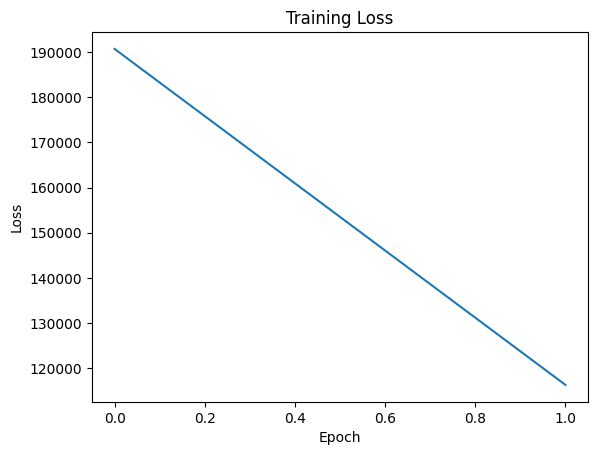

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
my_vectors = model.in_emb.weight.data.cpu().numpy()

In [12]:
!pip install gensim
from gensim.models import Word2Vec

gensim_model = Word2Vec(
    sentences=[tokens],
    vector_size=100,
    window=2,
    min_count=5,
    sg=1,
    negative=5,
    workers=4
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 31.4 MB/s eta 0:00:00:00:0100:01


In [14]:
from numpy.linalg import norm

def cosine(a, b):
    return np.dot(a,b) / (norm(a) * norm(b))

test_words = [
    "king", "queen", "man", "woman",
    "doctor", "nurse", "engineer", "teacher",
    "paris", "france", "rome", "italy",
    "computer", "science", "data", "algorithm"
]

print("Word | Cosine(My, Gensim)")
print("\n")

for w in test_words:
    if w in word2index and w in gensim_model.wv:
        v1 = my_vectors[word2index[w]]
        v2 = gensim_model.wv[w]
        print(w, cosine(v1, v2))


Word | Cosine(My, Gensim)


king 0.011804899
queen 0.18611
man 0.17481437
woman -0.10959267
doctor 0.08868435
nurse 0.08159551
engineer -0.09834265
teacher 0.1385871
paris 0.004948162
france -0.10081866
rome 0.25080743
italy -0.07964758
computer -0.12260479
science -0.028613994
data -0.064236134
algorithm 0.04894454


In [19]:
def nearest(word, emb, topk=5):
    v = emb[word2index[word]]
    sims = []
    for w in word2index:
        sims.append((w, cosine(v, emb[word2index[w]])))
    sims.sort(key=lambda x: -x[1])
    return sims[1:topk+1]

print("My Model Neighbours of King:", nearest("king", my_vectors))
print("Gensim Model Neighbours of King:", gensim_model.wv.most_similar("king"))

My Model Neighbours of King: [('iv', np.float32(0.74201995)), ('son', np.float32(0.7191274)), ('kings', np.float32(0.6848011)), ('duke', np.float32(0.68268836)), ('prince', np.float32(0.67836726))]
Gensim Model Neighbours of King: [('bovine', 0.40794503688812256), ('playing', 0.3945949971675873), ('bootable', 0.39242562651634216), ('idea', 0.3752402067184448), ('keyer', 0.37115561962127686), ('leutze', 0.36793747544288635), ('tires', 0.3677760362625122), ('ideological', 0.364501953125), ('crowley', 0.3602718710899353), ('sena', 0.3583014905452728)]


In [20]:
def analogy(a,b,c, emb):
    target = emb[word2index[a]] - emb[word2index[b]] + emb[word2index[c]]
    best = None
    best_score = -1

    for w in word2index:
        if w in [a,b,c]:
            continue
        score = cosine(target, emb[word2index[w]])
        if score > best_score:
            best_score = score
            best = w
    return best

print("My Model: king - man + woman =", analogy("king","man","woman",my_vectors))
print("Gensim Model: king - man + woman =", gensim_model.wv.most_similar(positive=["king","woman"], negative=["man"], topn=1))

My Model: king - man + woman = son
Gensim Model: king - man + woman = [('barnacle', 0.44111886620521545)]


In [21]:
gender_pairs = [("he","she"),("man","woman"),("male","female")]

gender_vectors = []

for m,f in gender_pairs:
    if m in word2index and f in word2index:
        gender_vectors.append(my_vectors[word2index[m]] - my_vectors[word2index[f]])

gender_direction = np.mean(gender_vectors, axis=0)

In [22]:
def bias(word, emb, direction):
    return cosine(emb[word2index[word]], direction)

testing_words = ["doctor","nurse","engineer","teacher","scientist","programmer","homemaker"]

print("Word | Bias Score ( + : male, - : female)")

for w in testing_words:
    if w in word2index:
        print(w, bias(w, my_vectors, gender_direction))

Word | Bias Score ( + : male, - : female)
doctor -0.2054114
nurse -0.38515615
engineer -0.03405085
teacher -0.2123263
scientist -0.082129546
programmer 0.023200681
homemaker -0.042314563


In [23]:
def gensim_bias(word):
    return cosine(gensim_model.wv[word], gender_direction)

print("Gensim Bias:")

for w in testing_words:
    if w in gensim_model.wv:
        print(w, gensim_bias(w))

Gensim Bias:
doctor -0.08079234
nurse -0.12649901
engineer -0.03891857
teacher -0.0011415315
scientist 0.048179623
programmer 0.016343584
homemaker 0.07586352
